In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np

# Convert to raw text file

import csv
import numpy as np

directory='./data/'
file_name='Chip4_15and10um_100mM_KCl_pH8_01_flow_0005.atf'
output_file_name='Chip4_15and10um_100mM_KCl_pH8_01_flow_0005'

header_length=10

file_length=file_len(directory+file_name)


file_handle=open(directory+file_name, 'r')

csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')

output_filehandle=open(directory+output_file_name, 'w')



for i in range(header_length):
    line=csv_reader.next()
    
for row in csv_reader:
    output_filehandle.write(row[0] +'\t' + row[1] + '\n')    

# Load .atf

In [2]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    f.close()
    return i + 1

import csv
import numpy as np

directory='./data/'
file_name='Chip4_cell_0018.atf'

header_length=10

file_length=file_len(directory+file_name)


file_handle=open(directory+file_name, 'r')

csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')



time=np.zeros(file_length-header_length)
current=np.zeros(file_length-header_length)
#current=np.zeros(MAX_SIZE)


for i in range(header_length):
    csv_reader.next()
i=0
for row in csv_reader:
    time[i]=row[0]
    current[i]=row[1]
    i+=1

# Load text

In [3]:
def open_full_atf_file(file_name):
    file_length=file_len(file_name)
    file_handle=open(directory+file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    data=np.empty((file_length,2))
    i=0
    for row in csv_reader:
        data[i,0]=row[0]
        data[i,1]=row[1]
        i+=1
    
    return data


def open_raw_file(file_name, data_points=-1):
    # open full file
    if data_points == -1:
        data_points=file_len(file_name)
    
    data=np.empty((data_points,2))
        
    file_handle=open(file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    for i in range(data_points):
        row=csv_reader.next()
        data[i,0]=row[0]
        data[i,1]=row[1]
    
    return data

In [4]:
directory='./data/'
file_name='Chip4_15and10um_100mM_KCl_pH8_01_flow_0005'
data=open_raw_file(directory+file_name, 10000000)
#data=open_full_atf_file(directory+file_name)

In [5]:
baseline_avg_length=200
event_avg_length=5
trigger_sigma_threshold=4.5
baseline=np.empty((0,4))

current_index=0
while current_index+baseline_avg_length <= data.shape[0]:
    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
    baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg,\
                                    baseline_avg-trigger_sigma_threshold*baseline_sigma,\
                                    baseline_avg+trigger_sigma_threshold*baseline_sigma]]))
    current_index+=baseline_avg_length

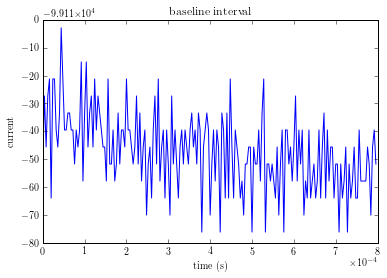

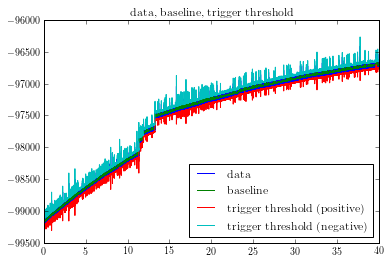

In [6]:
# Plot current over interval used to calculate the baseline
plt.plot(data[:baseline_avg_length,0], data[:baseline_avg_length,1])

plt.title('baseline interval')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('time (s)')
plt.ylabel('current')

plt.show()
# Plot baseline and trigger value
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(baseline[:,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (positive)')
plt.plot(baseline[:,0], baseline[:,3], label='trigger threshold (negative)')

plt.legend(loc='lower right')

plt.title('data, baseline, trigger threshold')
plt.show()

# Find events

## Method 1: Scanning

In [7]:
event_indices=np.empty((0,2),dtype=int)
baseline=np.empty((0,3))

current_index=0
baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg, baseline_avg-trigger_sigma_threshold*baseline_sigma]]))
trigger_threshold=trigger_sigma_threshold*baseline_sigma

keep_going = True
while keep_going == True:
    
    #baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
    #baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
    #baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg, baseline_avg-trigger_sigma_threshold*baseline_sigma]]))
    #trigger_threshold=trigger_sigma_threshold*baseline_sigma
    
    # Look for possible event
    start_trigger_found = False
    while start_trigger_found == False:                                         
        # Current exceeds trigger threshold
        if abs(data[current_index,1]-baseline_avg) >= trigger_threshold:     
            # Update baseline (i.e. in case of drift)
            baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
            baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
            baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg, baseline_avg-trigger_sigma_threshold*baseline_sigma]]))
            if abs(data[current_index,1]-baseline_avg) >= trigger_threshold: # Point still exceeds trigger threshold
                # Trigger
                # Get first point to exit baseline
                event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                while start_trigger_found == False:
                    if abs(event_avg)>=abs(baseline_avg):
                        start_index=current_index-event_avg_length/2+1
                        start_trigger_found = True
                    else:
                        event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                        current_index-=1#event_avg_length
                #start_index=current_index
        current_index+=1
    
    print '\tevent start found!'
    
    # Event found!
    # Look for possible event end
    stop_trigger_found = False
    event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
    while stop_trigger_found == False:     # Current returns to trigger threshold
        if abs(event_avg) >= abs(baseline_avg):
            stop_trigger_found = True
            stop_index=current_index+event_avg_length/2-1
            current_index=stop_index+1 # Just added
            event_indices=np.vstack((event_indices, [[start_index, stop_index]]))
        else:
            current_index+=1#event_avg_length
            event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
    print '\t\t t=', data[event_indices[-1,0],0]
    print '\t\t', event_indices[-1,0], event_indices[-1,1], event_indices[-1,1]-event_indices[-1,0]
    print '\tevent end found!\n'
        
    if current_index%1000000==0:
        print current_index

	event start found!
		 t= 0.128304
		32076 32174 98
	event end found!

	event start found!
		 t= 0.154152
		38538 38600 62
	event end found!

	event start found!
		 t= 0.20282
		50705 50788 83
	event end found!

	event start found!
		 t= 0.248548
		62137 62250 113
	event end found!

	event start found!
		 t= 0.29536
		73840 73851 11
	event end found!

	event start found!
		 t= 0.315164
		78791 78869 78
	event end found!

	event start found!
		 t= 0.34744
		86860 86942 82
	event end found!

	event start found!
		 t= 0.350568
		87642 87795 153
	event end found!

	event start found!
		 t= 0.445292
		111323 111412 89
	event end found!

	event start found!
		 t= 0.459892
		114973 115184 211
	event end found!

	event start found!
		 t= 0.4839
		120975 121187 212
	event end found!

	event start found!
		 t= 0.502
		125500 125618 118
	event end found!

	event start found!
		 t= 0.5925
		148125 148199 74
	event end found!

	event start found!
		 t= 0.598048
		149512 149587 75
	event end found!


/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [ ]:
delta=500
for i in range(event_indices.shape[0]):
    plt.plot(data[event_indices[i,0]-delta:event_indices[i,1]+delta,0], data[event_indices[i,0]-delta:event_indices[i,1]+delta,1],\
         c=(0,0,1))
    plt.plot(data[event_indices[i,0]:event_indices[i,1],0], data[event_indices[i,0]:event_indices[i,1],1],\
         c=(1,0,0), label='Event '+str(i))
    plt.xlim(data[event_indices[i,0]-delta,0],data[event_indices[i,1]+delta,0])
    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('time (s)')
    plt.ylabel(r'current ($\micro$A)')
    plt.legend(loc='lower left')
    plt.show()
    
plt.plot(data[:,0], data[:,1], zorder=1, label='Data')
plt.scatter(data[event_indices[:,0],0], data[event_indices[:,0],1], s=100, c=(1,0,0), zorder=10, label='Events')
plt.plot(baseline[:,0], baseline[:,1], lw=3, label='Baseline', zorder=10)
plt.plot(baseline[:,0], baseline[:,2], lw=3, label='Threshold')
plt.xlim(data[0,0], data[-1,0])


plt.legend(loc='lower left')
plt.xlabel('time (s)')
plt.ylabel(r'current ($\micro$A)')

plt.show()

# Find peaks

## Method 1: k-means clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
event_num=124
event_data=data[event_indices[event_num,0]:event_indices[event_num,1],:]
plt.plot(event_data[:,0], event_data[:,1])
plt.show()

In [ ]:
n_clusters=5
model=KMeans(n_clusters)
model.fit(event_data)

In [ ]:
plt.plot(event_data[:,0], event_data[:,1])
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1])
plt.show()

## Method 2. Increase/Decrease clustering

In [ ]:
import random

In [ ]:
event_num=124
event_data=data[event_indices[event_num,0]:event_indices[event_num,1],:]
plt.plot(event_data[:,0], event_data[:,1])
plt.show()

In [ ]:
inc_dec_list=np.empty((event_data.shape[0]-1,2))
for i in range(event_data.shape[0]-1):
    inc_dec_list[i,0]=event_data[i,0]
    if event_data[i,1]>=event_data[i+1,1]:
        inc_dec_list[i,1]=-1+.4*random.random()
    else:
        inc_dec_list[i,1]=1+.4*random.random()

In [ ]:
plt.scatter(inc_dec_list[:,0],inc_dec_list[:,1])
plt.xlim(inc_dec_list[0,0], inc_dec_list[-1,0])
plt.show()

## Method 3: 3 level clustering of current

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
event_num=124
event_data=data[event_indices[event_num,0]:event_indices[event_num,1],:]
plt.plot(event_data[:,0], event_data[:,1])
plt.xlim(event_data[0,0], event_data[-1,0])
plt.show()

In [ ]:
print event_data.shape

In [ ]:
model=KMeans(n_clusters=3)
predictions=model.fit_predict(event_data[:,1].reshape(-1,1)).reshape(-1,1)

In [ ]:
plt.scatter(event_data[:,0], event_data[:,1], c=predictions[:,0], zorder=10)
for i in range(model.cluster_centers_.shape[0]):
    plt.plot([-1000,1000],[model.cluster_centers_[i], model.cluster_centers_[i]], lw=5)
plt.imshow(Z, interpolation='bilinear', # creates background image
                origin='lower', cmap=cm.Blues, 
                extent=(-3,3,-2,2))
plt.xlim(event_data[0,0], event_data[-1,0])    
plt.show()

In [ ]:
Z=np.zeros((1000., 1))
for i in range

In [ ]:
im = plt.imshow(Z, interpolation='bilinear', # creates background image
                origin='lower', cmap=cm.Blues, 
                extent=(-3,3,-2,2))